## Notebook to scan PD risk and eQTL results for colocalization

In [1]:
!date

Fri Jul 23 14:50:38 UTC 2021


#### import libraries and set notebook variables

In [2]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf
import concurrent.futures
import seaborn as sns
import matplotlib.pyplot as plt

In [3]:
# parameters
cohort = 'foundin'

In [4]:
# naming

# directories
home_dir = '/home/jupyter'
wrk_dir = f'{home_dir}/{cohort}/eqtl'
expr_dir = f'{wrk_dir}/expression'
genos_dir = f'{wrk_dir}/genotypes'
tensorqtl_dir = f'{wrk_dir}/tensorqtl'
results_dir = f'{wrk_dir}/results'
gwas_dir = f'{wrk_dir}/gwas'

# input files
gencode_pkl = f'{expr_dir}/gencode_v29.lncipedia_v5_2_hc.annotation.pkl'
eqtl_results_file = f'{results_dir}/{cohort}.cis.csv'
meta5_st2_clean_file = f'{gwas_dir}/pd.table_s2.clean.txt'
meta5_stats_file = f'{gwas_dir}/pdmeta_sumstats_hg38.h5'

# output files

# constant values
autosomes = [str(x) for x in list(range(1,23))]
alpha_value = 0.05
capture_out = !(nproc)
max_threads = int(capture_out[0])


#### analysis functions

In [5]:
def mixed_model(formula, df, group_name):
    model = sm.MixedLM.from_formula(formula, df, groups=df[group_name])
    result = model.fit()
    return result

def regress_tscores_keep(this_df):
    ret_value = False
    # run the regression, mixed effects model with day as random effect
    this_formula = 'gwas_tscore_abs ~ eqtl_tscore_abs'
    grouping = 'day'
    result = mixed_model(this_formula, this_df, grouping)
#     print(result.summary())
    term = 'eqtl_tscore_abs'
#     print(['feature', 'coef', 'stderr', 'term_cnt', 'p-value'])
#     print(result.params[term], result.bse[term], 
#           result.params.shape[0], result.pvalues[term])    
    return [result.params[term], result.bse[term], 
            result.params.shape[0], result.pvalues[term]]

def create_merged_df_to_regress(eqtl_df, pheno_id, gwas_df):
    pheno_df = eqtl_df.loc[eqtl_df['phenotype_id'] == pheno_id]
    merged_df = pheno_df.merge(gwas_df, how='inner', 
                               left_on='variant_id', right_on='SNP')
    # will test regression on absolute t-score instead of say p-value
    merged_df['day'] =  merged_df['day'].astype(object)
    merged_df['gwas_tscore_abs'] = np.abs(merged_df['b']/merged_df['se'])
    merged_df['eqtl_tscore_abs'] = np.abs(merged_df['slope']/merged_df['slope_se'])

    # for regression will only consider variants that are nominally
    # significant in gwas or eqtl
    df_to_return = merged_df.loc[(merged_df['pval_nominal'] < alpha_value) | 
                                 (merged_df['p'] < alpha_value)]
    #     print(pheno_df.shape, merged_df.shape, alpha_df.shape)
    return df_to_return

def load_chrom_result(chrom, days, in_dir, cohort):
    # have to do pass to find all phenos to possible capture
    df_to_return = None
    phenos_oi = []
    for day in days:
        chrom_file = f'{in_dir}/{cohort}.{day}.cis_qtl_pairs.chr{chrom}.parquet'
        chrom_eqtl_df = pd.read_parquet(chrom_file)
        oi_chrom_eqtl_df = chrom_eqtl_df.loc[chrom_eqtl_df['pval_nominal'] < max_pvalue]
        oi_results = oi_chrom_eqtl_df.loc[oi_chrom_eqtl_df['variant_id'].isin(variants_oi_df['SNP'])]
        phenos_oi = phenos_oi + list(oi_results['phenotype_id'].unique())

    # do pass to keep results that belong those phenos
    for day in days:
        chrom_file = f'{in_dir}/{cohort}.{day}.cis_qtl_pairs.chr{chrom}.parquet'
        chrom_eqtl_df = pd.read_parquet(chrom_file)
        possible_results_oi = chrom_eqtl_df.loc[chrom_eqtl_df['phenotype_id'].isin(phenos_oi)].copy()
        possible_results_oi['day'] = day
        df_to_return = pd.concat([df_to_return, possible_results_oi])
    return phenos_oi, df_to_return

def process_regression_check(chrom, days, in_dir, cohort, gwas_df):
    results_to_keep = None
    phenos_oi, results_to_test = load_chrom_result(chrom, days, in_dir, cohort)
    print(f'chr {chrom} shape {results_to_test.shape}')
    # display(results_to_test.sample(5))

    # test the GWAS~eQTL regression for possible significance
    for phenotype_id in phenos_oi:
        alpha_df = create_merged_df_to_regress(results_to_test, phenotype_id, gwas_df)
        
        # ['coef', 'stderr', 'term_cnt', 'p-value']
        ret_vals = regress_tscores_keep(alpha_df)
        # must have postive coefficient and nomically significant p-value
        if ret_vals[0] > 0 and ret_vals[3] < alpha_value:
            results_to_keep = pd.concat([results_to_keep, alpha_df])
            
#         if phenotype_id == 'ENSG00000117280.12':
#             print(ret_vals)
    return results_to_keep

#### load the gencode annotations

In [6]:
%%time
gencode_df = pd.read_pickle(gencode_pkl)
# drop the ont and tag columns
discard_cols = gencode_df.columns[(gencode_df.columns.str.startswith('ont:')) |
                                (gencode_df.columns.str.startswith('tag:'))]
gencode_df.drop(columns=discard_cols, inplace=True)
# should only be autosomal but sometimes annotation quirks allow in others, so force
gencode_df = gencode_df.loc[(gencode_df['seqname'].str.startswith('chr')) & 
                           (~gencode_df['seqname'].isin(['chrX','chrY','chrM']))]
# every now and again having problem with mics_RNA genes mapping every chrom so drop
gencode_df = gencode_df.loc[~gencode_df['gene_type'].isin(['misc_RNA'])]
print(gencode_df.shape)
display(gencode_df.head())

(2955698, 50)


,seqname,source,feature,start,end,score,strand,frame,ID,ccdsid,...,transcript_alias_4,transcript_alias_5,transcript_alias_6,transcript_alias_7,transcript_alias_8,transcript_alias_9,transcript_id,transcript_name,transcript_support_level,transcript_type
0,chr10,ENSEMBL,CDS,100275465,100275493,.,-,2,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,ENST00000614731.4,BLOC1S2-205,2,protein_coding
1,chr10,ENSEMBL,CDS,100275465,100275493,.,-,2,NaN,CCDS73179.1,...,NaN,NaN,NaN,NaN,NaN,NaN,ENST00000618916.4,BLOC1S2-206,5,protein_coding
2,chr10,ENSEMBL,CDS,100280124,100280228,.,-,2,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,ENST00000614731.4,BLOC1S2-205,2,protein_coding
3,chr10,ENSEMBL,CDS,100280124,100280228,.,-,2,NaN,CCDS73179.1,...,NaN,NaN,NaN,NaN,NaN,NaN,ENST00000618916.4,BLOC1S2-206,5,protein_coding
4,chr10,ENSEMBL,CDS,100280934,100281053,.,-,2,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,ENST00000614731.4,BLOC1S2-205,2,protein_coding


CPU times: user 11.3 s, sys: 3.72 s, total: 15 s
Wall time: 15 s


#### load the risk variants of interest

In [7]:
%%time
variants_oi_df = pd.read_csv(meta5_st2_clean_file, sep='\t')
print(variants_oi_df.shape)
variants_oi_df.head()

(91, 12)
CPU times: user 2.4 ms, sys: 3.52 ms, total: 5.92 ms
Wall time: 4.43 ms


,SNP,CHR,BP,Nearest_Gene,QTL_Nominated_Gene,Effect_allele,Other_allele,EAF,Beta_all_studies,SE_all_studies,P_all_studies,P_COJO_all_studies
0,rs114138760,1,154898185,PMVK,NaN,c,g,0.0112,0.2812,0.0478,4.190000e-09,1.090000e-08
1,rs35749011,1,155135036,KRTCAP2,EFNA3,a,g,0.0169,0.6068,0.0342,1.720000e-70,3.820000e-77
2,rs76763715,1,155205634,GBAP1,NaN,t,c,0.9953,-0.7467,0.0765,1.590000e-22,9.900000e-23
3,rs6658353,1,161469054,FCGR2A,FCGR2A,c,g,0.5011,0.0650,0.0094,6.100000e-12,4.690000e-12
4,rs11578699,1,171719769,VAMP4,VAMP4,t,c,0.1949,-0.0704,0.0120,4.470000e-09,4.450000e-09


#### load the full gwas summary stats

In [8]:
%%time
gwas_stats_df = pd.read_hdf(meta5_stats_file)
print(gwas_stats_df.shape)
display(gwas_stats_df.sample(5))

(7769022, 11)


,SNP,A1,A2,freq,b,se,p,N,chr,position,id
6929066,rs73148245,T,C,0.0568,0.0427,0.0233,0.06648,1460059,chr7,78191558,rs73148245
358340,rs72829788,A,G,0.0377,-0.0022,0.0267,0.93310,1460059,chr10,85522541,rs72829788
7387943,rs13267335,A,C,0.7094,0.0100,0.0108,0.35230,1474097,chr8,83540898,rs13267335
172944,rs12250366,T,C,0.0628,-0.0476,0.0275,0.08386,1349931,chr10,27328144,rs12250366
5974515,rs35427760,T,C,0.8604,-0.0303,0.0139,0.02966,1474097,chr5,80582117,rs35427760


CPU times: user 28 s, sys: 2.15 s, total: 30.2 s
Wall time: 30.4 s


#### load the eQTL

In [9]:
eqtl_df = pd.read_csv(eqtl_results_file)
print(eqtl_df.shape)
number_genes = len(eqtl_df['phenotype_id'].unique())
print(f'eqtl for {number_genes} genes')
eqtl_df.head()

(1903, 15)
eqtl for 537 genes


,phenotype_id,variant_id,tss_distance,maf,ma_samples,ma_count,pval_nominal,slope,slope_se,cispair,day,log10_pvalue,t_score,t_score_abs,is_sig
0,ENSG00000154719.13,rs12386284,-89761,0.271277,46,51,4.835922e-08,-0.902316,0.151687,ENSG00000154719.13:rs12386284,da0,7.315521,-5.948552,5.948552,1
1,ENSG00000154719.13,rs8129399,17837,0.271277,46,51,1.205365e-06,-0.815778,0.156923,ENSG00000154719.13:rs8129399,da0,5.918881,-5.198576,5.198576,0
2,lnc_PCNT_2,rs2839204,3868,0.398936,58,75,4.804233e-11,-0.866399,0.116207,lnc_PCNT_2:rs2839204,da0,10.318376,-7.455651,7.455651,1
3,ENSG00000160194.17,rs4148974,23966,0.111702,20,21,2.153011e-11,-1.436483,0.188390,ENSG00000160194.17:rs4148974,da0,10.666954,-7.625058,7.625058,1
4,ENSG00000159228.12,rs2835269,7480,0.069149,12,13,2.049270e-05,-1.155655,0.257295,ENSG00000159228.12:rs2835269,da0,4.688401,-4.491549,4.491549,0


#### which day are present in the results (typically will be all in cohort)

In [10]:
days = sorted(list(eqtl_df['day'].unique()))
print(days)

['da0', 'da25', 'da65']


#### grab the max pval_nominal and max pval_beta

In [11]:
max_pvalue = eqtl_df[eqtl_df['is_sig'] == 1]['pval_nominal'].max()
print(f'max p-value: {max_pvalue}')
max_pvalue = 0.00001
print(f'hardcoded max p-value: {max_pvalue}')

max p-value: 1.4972197013743408e-07
hardcoded max p-value: 1e-05


#### see if any of the top significant results happen to be risk independent variants

In [12]:
def check_eqtls_for_variants(eqtl_df, variants_df, gencode_df):
    eqtl_variants_oi_df = eqtl_df.loc[eqtl_df['variant_id'].isin(variants_df['SNP'])]
    print(eqtl_variants_oi_df.shape)
    this_cnt = len(eqtl_variants_oi_df['variant_id'].unique())
    print(f'variants {this_cnt}')
    print(eqtl_variants_oi_df['variant_id'].unique())
    this_cnt = len(eqtl_variants_oi_df['phenotype_id'].unique())
    print(f'genes {this_cnt}')
    oi_genes = gencode_df.loc[gencode_df['gene_id'].isin(eqtl_variants_oi_df['phenotype_id']), 
                              ['gene_name']]['gene_name'].unique()
    print(oi_genes)
    return eqtl_variants_oi_df

In [13]:
risk_genes = check_eqtls_for_variants(eqtl_df, variants_oi_df, gencode_df)
if len(risk_genes) > 0:
    display(risk_genes.head())

(0, 15)
variants 0
[]
genes 0
[]


#### now load rest of results and see if risk index variants are eQTL

In [14]:
import warnings
# warnings.filterwarnings(action='once')
warnings.filterwarnings('ignore')

In [15]:
%%time

fs_list = []
lm_results = []
with concurrent.futures.ProcessPoolExecutor() as ppe:
    for chrom in autosomes:
        fs_list.append(ppe.submit(process_regression_check, chrom, days, 
                                  tensorqtl_dir, cohort, gwas_stats_df))
# for future in concurrent.futures.as_completed(fs_list):
#     lm_results.append(future.result())

# # flatten the list
# results_to_keep = pd.concat([item for item in lm_results])

chr 1 shape (47384, 10)
chr 2 shape (4056, 10)
chr 3 shape (57057, 10)
chr 4 shape (0, 10)
chr 5 shape (37029, 10)
chr 6 shape (0, 10)
chr 7 shape (20394, 10)
chr 8 shape (0, 10)
chr 9 shape (0, 10)
chr 10 shape (0, 10)
chr 11 shape (0, 10)
chr 12 shape (0, 10)
chr 13 shape (0, 10)
chr 14 shape (0, 10)
chr 15 shape (0, 10)
chr 16 shape (0, 10)
chr 17 shape (140079, 10)
chr 18 shape (0, 10)
chr 19 shape (0, 10)
chr 20 shape (0, 10)
chr 21 shape (0, 10)
chr 22 shape (0, 10)
CPU times: user 3min 18s, sys: 29.4 s, total: 3min 47s
Wall time: 5min 44s


In [16]:
for future in concurrent.futures.as_completed(fs_list):
    lm_results.append(future.result())

# flatten the list
results_to_keep = pd.concat([item for item in lm_results])

In [17]:
print(results_to_keep.shape)
display(results_to_keep.sample(5))

(101371, 23)


,phenotype_id,variant_id,tss_distance,maf,ma_samples,ma_count,pval_nominal,slope,slope_se,day,...,freq,b,se,p,N,chr,position,id,gwas_tscore_abs,eqtl_tscore_abs
12739,lnc_RHEX_7,rs76085699,924594,0.123656,20,23,0.704051,0.071134,0.186678,da25,...,0.1173,0.0465,0.0169,0.005890,1460243,chr1,206738030,rs76085699,2.751479,0.381055
5888,lnc_PLEKHM1_4,rs4792884,282454,0.098901,16,18,0.561315,0.136402,0.233933,da65,...,0.9072,-0.0649,0.0169,0.000126,1471960,chr17,45798582,rs4792884,3.840237,0.583079
6998,KLHL7_DT,rs7779799,-225993,0.093407,16,17,0.038022,-0.533411,0.253284,da65,...,0.0818,0.0417,0.0224,0.062040,1474097,chr7,22879710,rs7779799,1.861607,2.105983
122,lnc_PLEKHM1_3,rs11651271,-966682,0.291209,45,53,0.898854,0.021248,0.166686,da65,...,0.7221,-0.0473,0.0114,0.000031,1462380,chr17,44553782,rs11651271,4.149123,0.127472
3988,ENSG00000196542.8,rs9840389,-291611,0.166667,27,31,0.142983,-0.284168,0.192324,da25,...,0.1927,-0.0382,0.0121,0.001615,1474097,chr3,161081269,rs9840389,3.157025,1.477544


In [18]:
print(len(results_to_keep['phenotype_id'].unique()))
print(results_to_keep['phenotype_id'].unique())

15
['lnc_RHEX_7' 'lnc_RHEX_8' 'KLHL7_DT' 'lnc_PLEKHM1_3' 'KANSL1_AS1'
 'ENSG00000214425.7' 'lnc_PLEKHM1_4' 'ENSG00000263503.1'
 'lnc_LINC02210_CRHR1_7' 'ENSG00000238083.7' 'lnc_NSF_2'
 'ENSG00000196542.8' 'ENSG00000229089.8' 'ENSG00000145725.19'
 'ENSG00000175749.11']


In [19]:
genes_kept  = gencode_df.loc[gencode_df['gene_id'].isin(results_to_keep['phenotype_id']), 
                             ['gene_name']]['gene_name'].unique()
print(len(genes_kept))
print(genes_kept)

15
['LRRC37A2' 'LRRC37A4P' 'MAPK8IP1P2' 'lnc-PLEKHM1-3' 'lnc-PLEKHM1-4'
 'lnc-LINC02210-CRHR1-7' 'KANSL1-AS1' 'lnc-NSF-2' 'lnc-RHEX-7'
 'lnc-RHEX-8' 'ANKRD20A8P' 'SPTSSB' 'PPIP5K2' 'EIF3KP1' 'KLHL7-DT']


In [20]:
import random
phenotype_id = random.choice(results_to_keep['phenotype_id'].unique())
print(phenotype_id)

lnc_NSF_2


In [21]:
gencode_df.loc[gencode_df['gene_id'] == phenotype_id, 
               ['gene_name']]['gene_name'].unique()

array(['lnc-NSF-2'], dtype=object)

In [22]:
# phenotype_id = 'ENSG00000143537.13'
# phenotype_id = 'ENSG00000164733.20'
temp = results_to_keep.loc[results_to_keep['phenotype_id'] == phenotype_id]
print(temp.shape)
display(temp.head())

(2714, 23)


,phenotype_id,variant_id,tss_distance,maf,ma_samples,ma_count,pval_nominal,slope,slope_se,day,...,freq,b,se,p,N,chr,position,id,gwas_tscore_abs,eqtl_tscore_abs
5,lnc_NSF_2,rs140587036,-914623,0.016484,3,3,0.017257,1.416826,0.583871,da65,...,0.0183,0.0145,0.0487,7.650000e-01,1362970,chr17,45628711,rs140587036,0.297741,2.426608
6,lnc_NSF_2,rs142822273,-914272,0.021277,4,4,0.797588,-0.135902,0.528361,da0,...,0.9777,0.3847,0.1207,1.432000e-03,25028,chr17,45629062,rs142822273,3.187241,0.257214
7,lnc_NSF_2,rs142822273,-914272,0.021505,4,4,0.729509,0.179996,0.518952,da25,...,0.9777,0.3847,0.1207,1.432000e-03,25028,chr17,45629062,rs142822273,3.187241,0.346845
8,lnc_NSF_2,rs142822273,-914272,0.021978,4,4,0.096780,0.867692,0.516981,da65,...,0.9777,0.3847,0.1207,1.432000e-03,25028,chr17,45629062,rs142822273,3.187241,1.678384
9,lnc_NSF_2,rs1635303,-909867,0.138298,26,26,0.054583,-0.455091,0.233738,da0,...,0.1884,0.0948,0.0186,3.741000e-07,907933,chr17,45633467,rs1635303,5.096774,1.947014


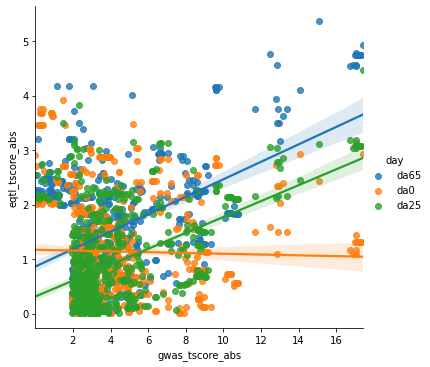

In [23]:
sns.lmplot(x='gwas_tscore_abs', y='eqtl_tscore_abs', hue='day', data=temp)

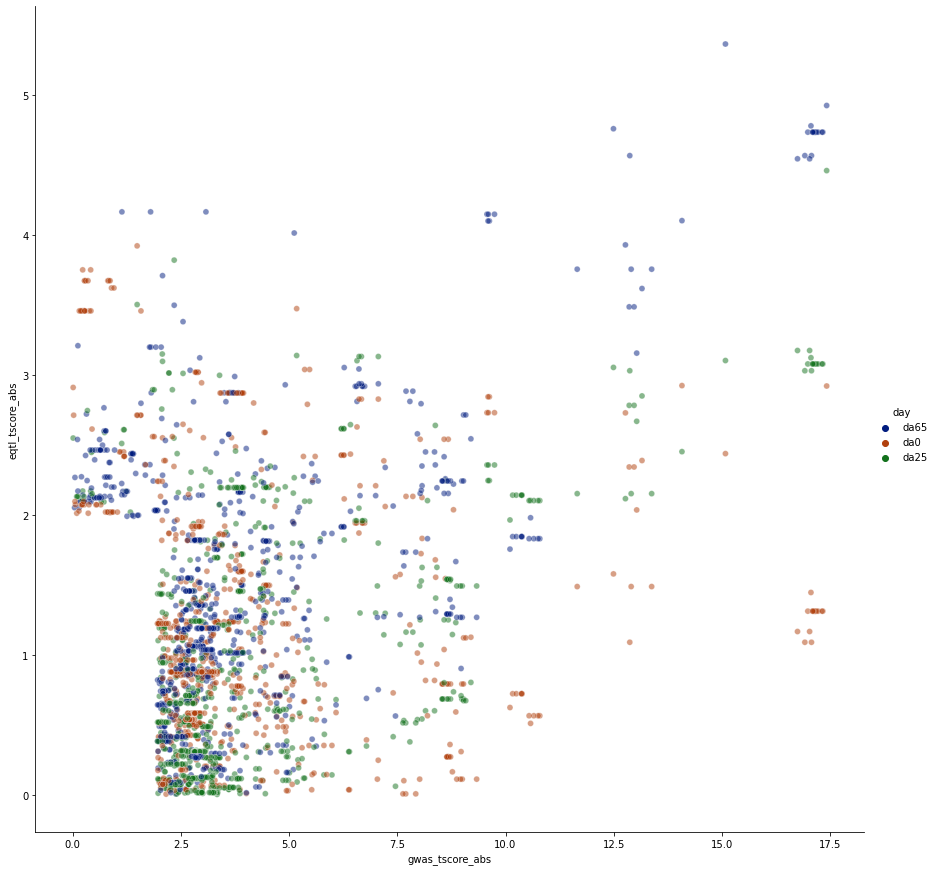

In [24]:
sns.relplot(x='gwas_tscore_abs', 
            y='eqtl_tscore_abs', 
            hue='day', alpha=.5, palette="dark", 
            height=12, data=temp) 

In [25]:
this_formula = 'gwas_tscore_abs ~ eqtl_tscore_abs'
grouping = 'day'
result = mixed_model(this_formula, temp, grouping)
print(result.summary())

            Mixed Linear Model Regression Results
Model:            MixedLM Dependent Variable: gwas_tscore_abs
No. Observations: 2714    Method:             REML           
No. Groups:       3       Scale:              7.5109         
Min. group size:  861     Log-Likelihood:     -6593.2602     
Max. group size:  949     Converged:          Yes            
Mean group size:  904.7                                      
-------------------------------------------------------------
                    Coef. Std.Err.   z    P>|z| [0.025 0.975]
-------------------------------------------------------------
Intercept           2.727    0.260 10.508 0.000  2.218  3.236
eqtl_tscore_abs     1.026    0.059 17.488 0.000  0.911  1.141
Group Var           0.180    0.069                           



In [26]:
term = 'eqtl_tscore_abs'
print(['feature', 'coef', 'stderr', 'term_cnt', 'p-value'])
print(result.params[term], result.bse[term], 
      result.params.shape[0], result.pvalues[term])

['feature', 'coef', 'stderr', 'term_cnt', 'p-value']
1.0264085969328105 0.05869131133759668 3 1.7606748652752925e-68


In [27]:
this_formula = 'gwas_tscore_abs ~ eqtl_tscore_abs'
reg_model = smf.ols(this_formula, data=temp).fit()
print(reg_model.summary())

                            OLS Regression Results                            
Dep. Variable:        gwas_tscore_abs   R-squared:                       0.090
Model:                            OLS   Adj. R-squared:                  0.090
Method:                 Least Squares   F-statistic:                     267.7
Date:                Fri, 23 Jul 2021   Prob (F-statistic):           1.83e-57
Time:                        14:57:11   Log-Likelihood:                -6606.4
No. Observations:                2714   AIC:                         1.322e+04
Df Residuals:                    2712   BIC:                         1.323e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           2.8208      0.086     

In [28]:
temp.columns

Index(['phenotype_id', 'variant_id', 'tss_distance', 'maf', 'ma_samples',
       'ma_count', 'pval_nominal', 'slope', 'slope_se', 'day', 'SNP', 'A1',
       'A2', 'freq', 'b', 'se', 'p', 'N', 'chr', 'position', 'id',
       'gwas_tscore_abs', 'eqtl_tscore_abs'],
      dtype='object')

In [29]:
this_formula = 'gwas_tscore_abs ~ eqtl_tscore_abs + day'
reg_model = smf.ols(this_formula, data=temp).fit()
print(reg_model.summary())

                            OLS Regression Results                            
Dep. Variable:        gwas_tscore_abs   R-squared:                       0.104
Model:                            OLS   Adj. R-squared:                  0.103
Method:                 Least Squares   F-statistic:                     104.8
Date:                Fri, 23 Jul 2021   Prob (F-statistic):           3.38e-64
Time:                        14:57:11   Log-Likelihood:                -6585.2
No. Observations:                2714   AIC:                         1.318e+04
Df Residuals:                    2710   BIC:                         1.320e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           2.7420      0.113     

In [30]:
this_formula = 'gwas_tscore_abs ~ eqtl_tscore_abs + day + eqtl_tscore_abs * day'
reg_model = smf.ols(this_formula, data=temp).fit()
print(reg_model.summary())

                            OLS Regression Results                            
Dep. Variable:        gwas_tscore_abs   R-squared:                       0.155
Model:                            OLS   Adj. R-squared:                  0.154
Method:                 Least Squares   F-statistic:                     99.64
Date:                Fri, 23 Jul 2021   Prob (F-statistic):           1.15e-96
Time:                        14:57:11   Log-Likelihood:                -6505.0
No. Observations:                2714   AIC:                         1.302e+04
Df Residuals:                    2708   BIC:                         1.306e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                  coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------
Intercept         

In [31]:
temp['daynum'] = temp['day'].str.replace('da','').astype('int32')
this_formula = 'gwas_tscore_abs ~ eqtl_tscore_abs + (1|daynum)'
reg_model = smf.ols(this_formula, data=temp).fit()
print(reg_model.summary())

                            OLS Regression Results                            
Dep. Variable:        gwas_tscore_abs   R-squared:                       0.096
Model:                            OLS   Adj. R-squared:                  0.095
Method:                 Least Squares   F-statistic:                     143.6
Date:                Fri, 23 Jul 2021   Prob (F-statistic):           5.34e-60
Time:                        14:57:11   Log-Likelihood:                -6597.5
No. Observations:                2714   AIC:                         1.320e+04
Df Residuals:                    2711   BIC:                         1.322e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           3.0324      0.099     